In [3]:
# Calculating currents in each ring on pyfftw way (one dimensional)

import numpy as np
from Impedance_matrix import Mnm
from scipy.sparse.linalg import LinearOperator, bicgstab, gmres, minres, lobpcg, cg
from tqdm import tqdm
import pyfftw
import json


In [4]:
def make_circ(c):
    n = len(c)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            C[i][j] = c[j-i]
    return C

c = np.array([1, 2, 3])
C = make_circ(c)
print(C)

def make_toeplitz(t):
    n = (len(t)+1)//2
    T = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            T[i][j] = t[n-1 + j - i]
    return T
        
t = np.array([-2, -1, 0, 1, 2])
T = make_toeplitz(t)
print(T)


[[1. 2. 3.]
 [3. 1. 2.]
 [2. 3. 1.]]
[[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]


In [5]:
from scipy.linalg import solve
import scipy
from pyfftw import pyfftw

b = np.array([6, 6, 6])

x_exact_circ = solve(C, b)
print(x_exact_circ)


x_fast_circ = pyfftw.empty_aligned(3, dtype = 'complex128')
fft_x_fast_circ = pyfftw.empty_aligned(3, dtype = 'complex128')
ifft_x_fast_circ = pyfftw.empty_aligned(3, dtype = 'complex128')

b_fast = pyfftw.empty_aligned(3, dtype = 'complex128')
b_array = pyfftw.empty_aligned(3, dtype = 'complex128')
c_array = pyfftw.empty_aligned(3, dtype = 'complex128')
b_array[:] = b
c_array[:] = c

fft_b = pyfftw.empty_aligned(3, dtype = 'complex128')
fft_c = pyfftw.empty_aligned(3, dtype = 'complex128')
ifft_b = pyfftw.empty_aligned(3, dtype = 'complex128')
ifft_c = pyfftw.empty_aligned(3, dtype = 'complex128')

pyfftw.FFTW(b_array, fft_b).execute()
pyfftw.FFTW(c_array, fft_c).execute()
pyfftw.FFTW(b_array, ifft_b, direction = 'FFTW_BACKWARD').execute()
pyfftw.FFTW(c_array, ifft_c, direction = 'FFTW_BACKWARD').execute()

fft_x_fast_circ = fft_b/fft_c/3
pyfftw.FFTW(fft_x_fast_circ, x_fast_circ, direction = 'FFTW_BACKWARD').execute()
pyfftw.FFTW(x_fast_circ, ifft_x_fast_circ, direction = 'FFTW_BACKWARD').execute()
print(x_fast_circ)

Cx = pyfftw.empty_aligned(3, dtype = 'complex128')
pyfftw.FFTW(fft_c*ifft_x_fast_circ/3, Cx).execute()
print(Cx)
print(scipy.fft.fft(scipy.fft.ifft(x_exact_circ)*scipy.fft.fft(c)))




[1. 1. 1.]
[1.+0.j 1.+0.j 1.+0.j]
[6.+0.j 6.+0.j 6.+0.j]
[6.+0.j 6.-0.j 6.+0.j]


In [6]:
import pyfftw
import numpy as np

a_pyfftw = pyfftw.empty_aligned(10, dtype = 'complex128')
b_pyfftw = pyfftw.empty_aligned(10, dtype = 'complex128')

a_np = np.arange(10)
b_np = np.fft.fft(a_np)
a_pyfftw[:] = a_np

pyfftw.FFTW(a_pyfftw, b_pyfftw).execute()
print(np.linalg.norm(a_pyfftw-a_np, ord = 2))
print(np.linalg.norm(b_pyfftw-b_np, ord = 2))

0.0
4.39625888431457e-15


In [7]:
# Base PYFFTW method2
from scipy.sparse.linalg import lgmres, gmres
from scipy.sparse.linalg import LinearOperator
from Impedance_matrix import Mnm
# Function for creating circulant vectors
solvers = {
    'gmres': gmres,
    'lgmres': lgmres
}
def Circvec(rings_3d_str, rings_3d_col, data):
    Nz_str, Ny_str, Nx_str = rings_3d_str.shape
    Nz_col, Ny_col, Nx_col = rings_3d_col.shape
    nz, ny, nx = Nz_str + Nz_col - 1, Ny_str + Ny_col - 1, Nx_str + Nx_col - 1
    Z_circvecs = pyfftw.pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= Nx_col)
                x_col_id = x * (x < Nx_col)

                y_str_id = (ny - y) * (y >= Ny_col)
                y_col_id = y * (y < Ny_col)

                z_str_id = (nz - z) * (z >= Nz_col)
                z_col_id = z * (z < Nz_col)
                
                Z_circvecs[z][y][x] = Mnm(rings_3d_str[z_str_id][y_str_id][x_str_id], rings_3d_col[z_col_id][y_col_id][x_col_id], data)
    return Z_circvecs

def fft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    pyfftw.pyfftw.FFTW(i_vecs, ifft_i_vecs, axes = (0, 1, 2), direction='FFTW_BACKWARD').execute()
    pyfftw.pyfftw.FFTW(FFT_Z_circvecs * ifft_i_vecs/nz/ny/nx, ZI, axes = (0, 1, 2)).execute()
    
    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def pyfftw_solvesystem(Params, rings_4d, phi_0z_4d, Inductance = {}, find = 'Currents', tol = 1e-5):
    # Unpacking parameters
    Params['Solver_type'] = 'Fast_pyfftw'
    Omegas = Params['Omega']    
    solver = solvers[Params['Solver_name']]
    threads = Params['Threads']

    Omega = np.linspace(Omegas[0], Omegas[1], Omegas[2])
    
    rings = sum([rings_4d[orientation] for orientation in rings_4d], [])
    phi_0z = np.array(sum([phi_0z_4d[orientation] for orientation in phi_0z_4d], []))
    
    orientations = rings_4d.keys()
    for orientation in orientations:
        Nz, Ny, Nx = Params['N'][orientation]['nz'], Params['N'][orientation]['ny'], Params['N'][orientation]['nx']
        rings_4d[orientation] = np.array(rings_4d[orientation]).reshape(Nz, Ny, Nx)
        phi_0z_4d[orientation] = np.array(phi_0z_4d[orientation])
    Number = np.sum([value.size for value in rings_4d.values()])

    FFT_M_circvecs = {}
    i_vecs = {}
    ifft_i_vecs = {}
    MI_vecs = {}

    # Preparing empty arrays for pyfftw
    print('Cirvecs forming')
    for pos_str in tqdm(orientations):
        rings_str = rings_4d[pos_str]
        FFT_M_circvecs[pos_str] = {}
        i_vecs[pos_str] = {}
        ifft_i_vecs[pos_str] = {}
        MI_vecs[pos_str] = {}
        for pos_col in orientations:
            rings_col = rings_4d[pos_col]
            M_circvecs = Circvec(rings_str, rings_col, Inductance)

            N_circ = np.array(rings_str.shape) + np.array(rings_col.shape) - 1
            i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)
            MI_vecs[pos_str][pos_col] = pyfftw.pyfftw.empty_aligned(N_circ, dtype = 'complex128')

            FFT_M_circvecs[pos_str][pos_col] = pyfftw.pyfftw.empty_aligned(N_circ, dtype = 'complex128')
            ifft_i_vecs[pos_str][pos_col] = pyfftw.pyfftw.empty_aligned(N_circ, dtype = 'complex128')
            pyfftw.pyfftw.FFTW(M_circvecs, FFT_M_circvecs[pos_str][pos_col], axes = (0, 1, 2)).execute()
    print('Circvecs: Done')
    # Calculating diagonal of M matrix
    L, C, R = [], [], []
    for ring in rings:
        L.append(ring.L)
        C.append(ring.C)
        R.append(ring.R)
    L, C, R = np.array(L), np.array(C), np.array(R)
    M_0 = lambda Omega: (R - 1j * Omega * L + 1j/(Omega * C))/1j/Omega

    # Caclulating current in each ring
    print('FFT solving')
    CURRENTS = []
    I_old = np.ones(Number, dtype = np.complex128)/M_0(Omega[0])
    Phi_0z = phi_0z/np.max(abs(phi_0z))
    P = []
    for omega in tqdm(Omega):
        M_diag = M_0(omega)
        def LO(I):
            MI = M_diag * I
            # Make start and end indexes for each orientation
            start_str = 0
            end_str = 0
            for pos_str in orientations:
                end_str += rings_4d[pos_str].size

                start_col = 0
                end_col = 0
                for pos_col in orientations:
                    end_col += rings_4d[pos_col].size
                    MI[start_str: end_str] -= fft_dot(I[start_col:end_col].reshape(rings_4d[pos_col].shape),
                                                      MI_vecs[pos_str][pos_col],
                                                      FFT_M_circvecs[pos_str][pos_col],
                                                      i_vecs[pos_str][pos_col],
                                                      ifft_i_vecs[pos_str][pos_col])
                    start_col += rings_4d[pos_col].size
                start_str += rings_4d[pos_str].size
            return MI
        
        M = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=LO)
        I, info = solver(M, Phi_0z, x0 = I_old, rtol = tol, atol = 0)

        if info != 0:
            print(f'omega = {omega/2/np.pi/1e6} MHz did not converge')
        
        CURRENTS.append(I*np.max(abs(phi_0z)))
        start = 0
        p = []
        for pos in orientations:
            end = start + rings_4d[pos].size
            p.append(np.sum(I[start:end])/(end-start))
            start = end
        P.append(p)

        I_old = I

    P = np.array(P)*np.max(abs(phi_0z)) * Params['P_0z']

    print(f'FFT solving: Done, shape = {[(pos, rings_4d[pos].shape) for pos in orientations]}')
    Data = {}

    Data['Params'] = Params
    Data['Omega'] = Omega
    Data['Currents'] = CURRENTS
    Data['Polarization'] = P
    Data['Phi_0z'] = list(phi_0z)

    return Data

In [8]:
# Overchecking scipy method
import os
import scipy
import scipy.linalg
from Impedance_matrix import Matrix
from scipy.sparse.linalg import lgmres, gmres
from scipy.sparse.linalg import LinearOperator
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
# Calculating currents in each ring on pyfftw way (one dimensional)
solvers = {
    'gmres': gmres,
    'lgmres': lgmres
}
# Function for creating circulant vectors
def Circvec(rings_3d_str, rings_3d_col, data):
    Nz_str, Ny_str, Nx_str = rings_3d_str.shape
    Nz_col, Ny_col, Nx_col = rings_3d_col.shape
    nz, ny, nx = Nz_str + Nz_col - 1, Ny_str + Ny_col - 1, Nx_str + Nx_col - 1
    Z_circvecs = np.zeros((nz, ny, nx), dtype = complex)
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= Nx_col)
                x_col_id = x * (x < Nx_col)

                y_str_id = (ny - y) * (y >= Ny_col)
                y_col_id = y * (y < Ny_col)

                z_str_id = (nz - z) * (z >= Nz_col)
                z_col_id = z * (z < Nz_col)
                
                Z_circvecs[z][y][x] = Mnm(rings_3d_str[z_str_id][y_str_id][x_str_id], rings_3d_col[z_col_id][y_col_id][x_col_id], data)
    return Z_circvecs

def fft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    ifft_i_vecs = scipy.fft.ifftn(i_vecs, axes = (0, 1, 2))
    ZI = scipy.fft.fftn(FFT_Z_circvecs * ifft_i_vecs, axes = (0, 1, 2))

    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def ifft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    ifft_i_vecs = scipy.fft.ifftn(i_vecs, axes = (0, 1, 2))
    ZI = scipy.fft.fftn(ifft_i_vecs/FFT_Z_circvecs, axes = (0, 1, 2))

    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def scipy_solvesystem(Params, rings_4d, phi_0z_4d, Inductance = {}, find = 'Currents', tol = 1e-7):
    # Unpacking parameters
    Params['Solver_type'] = 'Fast_scipy'
    solve = solvers[Params['Solver_name']]
    Omegas = Params['Omega']    
    threads = Params['Threads']
    pyfftw.config.NUM_THREADS = threads
    Omega = np.linspace(Omegas[0], Omegas[1], Omegas[2])
    
    rings = sum([rings_4d[orientation] for orientation in rings_4d], [])
    phi_0z = np.array(sum([phi_0z_4d[orientation] for orientation in phi_0z_4d], []))
    M_matrix = Matrix(rings, Inductance)
    orientations = rings_4d.keys()
    for orientation in orientations:
        Nz, Ny, Nx = Params['N'][orientation]['nz'], Params['N'][orientation]['ny'], Params['N'][orientation]['nx']
        rings_4d[orientation] = np.array(rings_4d[orientation]).reshape(Nz, Ny, Nx)
        phi_0z_4d[orientation] = np.array(phi_0z_4d[orientation])
    Number = np.sum([value.size for value in rings_4d.values()])

    FFT_M_circvecs = {}
    i_vecs = {}
    ifft_i_vecs = {}
    MI_vecs = {}

    # Preparing empty arrays for pyfftw
    print('Cirvecs forming')
    for pos_str in tqdm(orientations):
        rings_str = rings_4d[pos_str]
        FFT_M_circvecs[pos_str] = {}
        i_vecs[pos_str] = {}
        ifft_i_vecs[pos_str] = {}
        MI_vecs[pos_str] = {}
        for pos_col in orientations:
            rings_col = rings_4d[pos_col]
            M_circvecs = Circvec(rings_str, rings_col, Inductance)

            N_circ = np.array(rings_str.shape) + np.array(rings_col.shape) - 1
            i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)
            MI_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)

            FFT_M_circvecs[pos_str][pos_col] = scipy.fft.fftn(M_circvecs, axes = (0, 1, 2))
            ifft_i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)

    print('Circvecs: Done')

    # Calculating diagonal of M matrix
    L, C, R = [], [], []
    for ring in rings:
        L.append(ring.L)
        C.append(ring.C)
        R.append(ring.R)
    L, C, R = np.array(L), np.array(C), np.array(R)
    M_0 = lambda Omega: (R - 1j * Omega * L + 1j/(Omega * C))/1j/Omega

    # Caclulating current in each ring
    print('FFT solving with preconditioner')
    CURRENTS = []
    I_old = np.ones(Number, dtype = np.complex128)/M_0(Omega[0])
    Phi_0z = phi_0z
    P = []
    P_straight = []
    Iters = []
    Conds = []
    Preconds = []
    Eigenvalues = []
    PrecondEigenvalues = []
    for omega in tqdm(Omega):
        M_diag = M_0(omega)
        def LO(I):
            MI = M_diag * I
            # Make start and end indexes for each orientation
            start_str = 0
            end_str = 0
            for pos_str in orientations:
                end_str += rings_4d[pos_str].size

                start_col = 0
                end_col = 0
                for pos_col in orientations:
                    end_col += rings_4d[pos_col].size
                    MI[start_str: end_str] -= fft_dot(I[start_col:end_col].reshape(rings_4d[pos_col].shape),
                                                      MI_vecs[pos_str][pos_col],
                                                      FFT_M_circvecs[pos_str][pos_col],
                                                      i_vecs[pos_str][pos_col],
                                                      ifft_i_vecs[pos_str][pos_col])
                    start_col += rings_4d[pos_col].size
                start_str += rings_4d[pos_str].size
            return MI
        # def invLO(I):
        #     MI = I/M_diag
        #     # Make start and end indexes for each orientation
        #     start_str = 0
        #     end_str = 0
        #     for pos_str in orientations:
        #         end_str += rings_4d[pos_str].size

        #         start_col = 0
        #         end_col = 0
        #         for pos_col in orientations:
        #             end_col += rings_4d[pos_col].size
        #             MI[start_str: end_str] -= ifft_dot(I[start_col:end_col].reshape(rings_4d[pos_col].shape),
        #                                               MI_vecs[pos_str][pos_col],
        #                                               FFT_M_circvecs[pos_str][pos_col],
        #                                               i_vecs[pos_str][pos_col],
        #                                               ifft_i_vecs[pos_str][pos_col])
        #             start_col += rings_4d[pos_col].size
        #         start_str += rings_4d[pos_str].size
        #     return I
        
        M = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=LO)
        # preconditioner = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=lambda x: x/M_diag)
        # preconditioner = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=invLO)
        # Переменная для хранения количества итераций
        # global iteration_count
        # iteration_count = 0

        # Функция обратного вызова для подсчета итераций

        I, info = solve(M, Phi_0z, x0 = I_old, rtol = tol, atol = 0)
        # Iters.append(iteration_count)
        # Z = np.diag(M_diag)-M_matrix
        #Conds.append(np.linalg.cond(Z))
        #Preconds.append(np.linalg.cond(Z/M_diag))
        #Eigenvalues.append(np.linalg.eigvals(Z))
        #PrecondEigenvalues.append(np.linalg.eigvals(Z/M_diag))
        I_straight = scipy.linalg.solve(np.diag(M_diag)-M_matrix, Phi_0z)
        if info != 0:
            print(f'f = {omega/2/np.pi/1e6} MHz did not converge')
        
        CURRENTS.append(I)
        start = 0
        p = []
        p_straight = []
        for pos in orientations:
            end = start + rings_4d[pos].size
            p.append(np.sum(I[start:end])/(end-start))
            p_straight.append(np.sum(I_straight[start:end])/(end-start))
            start = end
        P.append(p)
        P_straight.append(p_straight)

        I_old = I
    
    P = np.array(P) * Params['P_0z']
    P_straight = np.array(P_straight) * Params['P_0z']

    print(f'FFT solving: Done, shape = {[(pos, rings_4d[pos].shape) for pos in orientations]}')
    Data = {}

    #Data['Iters'] = Iters
    #Data['Conds'] = Conds
    #Data['Preconds'] = Preconds
    #Data['Eigenvalues'] = Eigenvalues
    #Data['PrecondEigenvalues'] = PrecondEigenvalues
    Data['Params'] = Params
    Data['Omega'] = Omega
    Data['Currents'] = CURRENTS
    Data['Polarization'] = P
    Data['Polarization_straight'] = P_straight
    Data['Phi_0z'] = list(phi_0z)

    return Data

In [9]:
# Base scipy method
import os
import scipy
import scipy.linalg
from Impedance_matrix import Mnm
from scipy.sparse.linalg import lgmres, gmres
from scipy.sparse.linalg import LinearOperator
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
# Calculating currents in each ring on pyfftw way (one dimensional)
solvers = {
    'gmres': gmres,
    'lgmres': lgmres
}
# Function for creating circulant vectors
def Circvec(rings_3d_str, rings_3d_col, data):
    Nz_str, Ny_str, Nx_str = rings_3d_str.shape
    Nz_col, Ny_col, Nx_col = rings_3d_col.shape
    nz, ny, nx = Nz_str + Nz_col - 1, Ny_str + Ny_col - 1, Nx_str + Nx_col - 1
    Z_circvecs = np.zeros((nz, ny, nx), dtype = complex)
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= Nx_col)
                x_col_id = x * (x < Nx_col)

                y_str_id = (ny - y) * (y >= Ny_col)
                y_col_id = y * (y < Ny_col)

                z_str_id = (nz - z) * (z >= Nz_col)
                z_col_id = z * (z < Nz_col)
                
                Z_circvecs[z][y][x] = Mnm(rings_3d_str[z_str_id][y_str_id][x_str_id], rings_3d_col[z_col_id][y_col_id][x_col_id], data)
    return Z_circvecs

def fft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    ifft_i_vecs = scipy.fft.ifftn(i_vecs, axes = (0, 1, 2))
    ZI = scipy.fft.fftn(FFT_Z_circvecs * ifft_i_vecs, axes = (0, 1, 2))

    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def ifft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    ifft_i_vecs = scipy.fft.ifftn(i_vecs, axes = (0, 1, 2))
    ZI = scipy.fft.fftn(ifft_i_vecs/FFT_Z_circvecs, axes = (0, 1, 2))

    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def fast_solvesystem(Params, rings_4d, phi_0z_4d, Inductance = {}, find = 'Currents', tol = 1e-7):
    # Unpacking parameters
    Params['Solver_type'] = 'Fast_scipy'
    solve = solvers[Params['Solver_name']]
    Omegas = Params['Omega']    
    threads = Params['Threads']
    pyfftw.config.NUM_THREADS = threads
    Omega = np.linspace(Omegas[0], Omegas[1], Omegas[2])
    
    rings = sum([rings_4d[orientation] for orientation in rings_4d], [])
    phi_0z = np.array(sum([phi_0z_4d[orientation] for orientation in phi_0z_4d], []))

    orientations = rings_4d.keys()
    for orientation in orientations:
        Nz, Ny, Nx = Params['N'][orientation]['nz'], Params['N'][orientation]['ny'], Params['N'][orientation]['nx']
        rings_4d[orientation] = np.array(rings_4d[orientation]).reshape(Nz, Ny, Nx)
        phi_0z_4d[orientation] = np.array(phi_0z_4d[orientation])
    Number = np.sum([value.size for value in rings_4d.values()])

    FFT_M_circvecs = {}
    i_vecs = {}
    ifft_i_vecs = {}
    MI_vecs = {}

    # Preparing empty arrays for pyfftw
    print('Cirvecs forming')
    for pos_str in tqdm(orientations):
        rings_str = rings_4d[pos_str]
        FFT_M_circvecs[pos_str] = {}
        i_vecs[pos_str] = {}
        ifft_i_vecs[pos_str] = {}
        MI_vecs[pos_str] = {}
        for pos_col in orientations:
            rings_col = rings_4d[pos_col]
            M_circvecs = Circvec(rings_str, rings_col, Inductance)

            N_circ = np.array(rings_str.shape) + np.array(rings_col.shape) - 1
            i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)
            MI_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)

            FFT_M_circvecs[pos_str][pos_col] = scipy.fft.fftn(M_circvecs, axes = (0, 1, 2))
            ifft_i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)

    print('Circvecs: Done')

    # Calculating diagonal of M matrix
    L, C, R = [], [], []
    for ring in rings:
        L.append(ring.L)
        C.append(ring.C)
        R.append(ring.R)
    L, C, R = np.array(L), np.array(C), np.array(R)
    M_0 = lambda Omega: (R - 1j * Omega * L + 1j/(Omega * C))/1j/Omega

    # Caclulating current in each ring
    print('FFT solving with preconditioner')
    CURRENTS = []
    I_old = np.ones(Number, dtype = np.complex128)/M_0(Omega[0])
    Phi_0z = phi_0z
    P = []

    for omega in tqdm(Omega):
        M_diag = M_0(omega)
        def LO(I):
            MI = M_diag * I
            # Make start and end indexes for each orientation
            start_str = 0
            end_str = 0
            for pos_str in orientations:
                end_str += rings_4d[pos_str].size

                start_col = 0
                end_col = 0
                for pos_col in orientations:
                    end_col += rings_4d[pos_col].size
                    MI[start_str: end_str] -= fft_dot(I[start_col:end_col].reshape(rings_4d[pos_col].shape),
                                                      MI_vecs[pos_str][pos_col],
                                                      FFT_M_circvecs[pos_str][pos_col],
                                                      i_vecs[pos_str][pos_col],
                                                      ifft_i_vecs[pos_str][pos_col])
                    start_col += rings_4d[pos_col].size
                start_str += rings_4d[pos_str].size
            return MI
        
        M = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=LO)

        # Функция обратного вызова для подсчета итераций

        I, info = solve(M, Phi_0z, x0 = I_old, rtol = tol, atol = 0)

        if info != 0:
            print(f'f = {omega/2/np.pi/1e6} MHz did not converge')
        
        CURRENTS.append(I)
        start = 0
        p = []
        for pos in orientations:
            end = start + rings_4d[pos].size
            p.append(np.sum(I[start:end])/(end-start))
            start = end
        P.append(p)

        I_old = I
    
    P = np.array(P) * Params['P_0z']
    P_straight = np.array(P_straight) * Params['P_0z']

    print(f'FFT solving: Done, shape = {[(pos, rings_4d[pos].shape) for pos in orientations]}')
    Data = {}

    Data['Params'] = Params
    Data['Omega'] = Omega
    Data['Currents'] = CURRENTS
    Data['Polarization'] = P
    Data['Phi_0z'] = list(phi_0z)

    return Data

In [10]:
# Base voltage method
import os
import scipy
import scipy.linalg
from scipy.sparse.linalg import lgmres, gmres
from Impedance_matrix import Mnm
from scipy.sparse.linalg import LinearOperator
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
# Calculating currents in each ring on pyfftw way (one dimensional)
solvers = {
    'gmres': gmres,
    'lgmres': lgmres
}
# Function for creating circulant vectors
def Circvec(rings_3d_str, rings_3d_col, data):
    Nz_str, Ny_str, Nx_str = rings_3d_str.shape
    Nz_col, Ny_col, Nx_col = rings_3d_col.shape
    nz, ny, nx = Nz_str + Nz_col - 1, Ny_str + Ny_col - 1, Nx_str + Nx_col - 1
    Z_circvecs = np.zeros((nz, ny, nx), dtype = complex)
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= Nx_col)
                x_col_id = x * (x < Nx_col)

                y_str_id = (ny - y) * (y >= Ny_col)
                y_col_id = y * (y < Ny_col)

                z_str_id = (nz - z) * (z >= Nz_col)
                z_col_id = z * (z < Nz_col)
                
                Z_circvecs[z][y][x] = Mnm(rings_3d_str[z_str_id][y_str_id][x_str_id], rings_3d_col[z_col_id][y_col_id][x_col_id], data)
    return Z_circvecs

def fft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    ifft_i_vecs = scipy.fft.ifftn(i_vecs, axes = (0, 1, 2))
    ZI = scipy.fft.fftn(FFT_Z_circvecs * ifft_i_vecs, axes = (0, 1, 2))

    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def ifft_dot(I, ZI, FFT_Z_circvecs, i_vecs, ifft_i_vecs):
    Nz, Ny, Nx = I.shape
    nz, ny, nx = i_vecs.shape

    i_vecs[:Nz, :Ny, :Nx] = I

    ifft_i_vecs = scipy.fft.ifftn(i_vecs, axes = (0, 1, 2))
    ZI = scipy.fft.fftn(ifft_i_vecs/FFT_Z_circvecs, axes = (0, 1, 2))

    return ZI[:nz - Nz + 1, :ny - Ny + 1, :nx - Nx + 1].ravel()

def volt_solvesystem(Params, rings_4d, phi_0z_4d, Inductance = {}, find = 'Currents', tol = 1e-7):
    # Unpacking parameters
    Params['Solver_type'] = 'Volt_fast'
    solve = solvers[Params['Solver_name']]
    Omegas = Params['Omega']    
    threads = Params['Threads']

    Omega = np.linspace(Omegas[0], Omegas[1], Omegas[2])
    
    rings = sum([rings_4d[orientation] for orientation in rings_4d], [])
    phi_0z = np.array(sum([phi_0z_4d[orientation] for orientation in phi_0z_4d], []))

    orientations = rings_4d.keys()
    for orientation in orientations:
        Nz, Ny, Nx = Params['N'][orientation]['nz'], Params['N'][orientation]['ny'], Params['N'][orientation]['nx']
        rings_4d[orientation] = np.array(rings_4d[orientation]).reshape(Nz, Ny, Nx)
        phi_0z_4d[orientation] = np.array(phi_0z_4d[orientation])
    Number = np.sum([value.size for value in rings_4d.values()])

    FFT_M_circvecs = {}
    i_vecs = {}
    ifft_i_vecs = {}
    MI_vecs = {}

    # Preparing empty arrays for pyfftw
    print('Cirvecs forming')
    for pos_str in tqdm(orientations):
        rings_str = rings_4d[pos_str]
        FFT_M_circvecs[pos_str] = {}
        i_vecs[pos_str] = {}
        ifft_i_vecs[pos_str] = {}
        MI_vecs[pos_str] = {}
        for pos_col in orientations:
            rings_col = rings_4d[pos_col]
            M_circvecs = Circvec(rings_str, rings_col, Inductance)

            N_circ = np.array(rings_str.shape) + np.array(rings_col.shape) - 1
            i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)
            MI_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)

            FFT_M_circvecs[pos_str][pos_col] = scipy.fft.fftn(M_circvecs, axes = (0, 1, 2))
            ifft_i_vecs[pos_str][pos_col] = np.zeros(N_circ, dtype=complex)

    print('Circvecs: Done')

    # Calculating diagonal of M matrix
    L, C, R = [], [], []
    for ring in rings:
        L.append(ring.L)
        C.append(ring.C)
        R.append(ring.R)
    L, C, R = np.array(L), np.array(C), np.array(R)
    
    M_0 = lambda Omega: (R - 1j * Omega * L + 1j/(Omega * C))/1j/Omega

    # Caclulating current in each ring
    print('FFT solving (voltage)')
    CURRENTS = []
    I_old = np.ones(Number, dtype = np.complex128)/M_0(Omega[0])
    Phi_0z = phi_0z
    P = []

    for omega in tqdm(Omega):
        M_diag = M_0(omega)
        def LO(I):
            MI = M_diag * I
            # Make start and end indexes for each orientation
            start_str = 0
            end_str = 0
            for pos_str in orientations:
                end_str += rings_4d[pos_str].size

                start_col = 0
                end_col = 0
                for pos_col in orientations:
                    end_col += rings_4d[pos_col].size
                    MI[start_str: end_str] -= fft_dot(I[start_col:end_col].reshape(rings_4d[pos_col].shape),
                                                      MI_vecs[pos_str][pos_col],
                                                      FFT_M_circvecs[pos_str][pos_col],
                                                      i_vecs[pos_str][pos_col],
                                                      ifft_i_vecs[pos_str][pos_col])
                    start_col += rings_4d[pos_col].size
                start_str += rings_4d[pos_str].size
            return MI/M_diag
        
        M = LinearOperator(dtype = np.complex128, shape=(Number, Number), matvec=LO)

        
        I, info = solve(M, Phi_0z/M_diag, x0 = I_old, rtol = tol, atol = 0)

        if info != 0:
            print(f'f = {omega/2/np.pi/1e6} MHz did not converge')
        
        CURRENTS.append(I)
        start = 0
        p = []
        for pos in orientations:
            end = start + rings_4d[pos].size
            p.append(np.sum(I[start:end])/(end-start))
            start = end
        P.append(p)

        I_old = I
    
    P = np.array(P) * Params['P_0z']

    print(f'FFT solving: Done, shape = {[(pos, rings_4d[pos].shape) for pos in orientations]}')
    Data = {}

    Data['Params'] = Params
    Data['Omega'] = Omega
    Data['Currents'] = CURRENTS
    Data['Polarization'] = P
    Data['Phi_0z'] = list(phi_0z)

    return Data

In [23]:
# Calculating currents in each ring for anizotropic system on straight way

import numpy as np
from scipy.linalg import solve
from Impedance_matrix import Matrix
from tqdm import tqdm

def straight_solvesystem(Params, rings_4d, phi_0z_4d, Inductance = {}, find = 'Voltage', tol = 0):
    Params['Solver_type'] = 'Straight'
    Omegas = Params['Omega']    
    Omega = np.linspace(Omegas[0], Omegas[1], Omegas[2])
    # Unpacking parameters
    # Solve system in currents terms and return currents in each ring
    rings = sum([rings_4d[orientation] for orientation in rings_4d], [])
    phi_0z = np.array(sum([phi_0z_4d[orientation] for orientation in phi_0z_4d], []))

    Number = len(rings)

    # Diagonal part
    L, C, R = [], [], []
    for ring in rings:
        L.append(ring.L)
        C.append(ring.C)
        R.append(ring.R)
    L, C, R = np.array(L), np.array(C), np.array(R)

    M_0 = lambda Omega: (R - 1j * Omega * L + 1j/(Omega * C))/1j/Omega
    P = []
    CURRENTS = []
    # External field
    Phi_0z = phi_0z/np.max(abs(phi_0z))

    print('Matrix forming')
    M = Matrix(rings, Data = Inductance)
    print('Matrix: Done')
    if find == 'Currents':
        print('Straight solving (Currents)')
        for omega in tqdm(Omega):
            # Solve equation (diag(Z_0)/jw - M)I = Phi_0z
            I = solve(np.diag(M_0(omega)) - M, Phi_0z)
            CURRENTS.append(I * np.max(abs(phi_0z)))
            start = 0
            p = []
            for pos in Params['Orientations']:
                end = start + Params['Numbers'][pos]
                p.append(np.sum(I[start:end])/(end-start))
                start = end
            P.append(p)
        P = np.array(P)*np.max(abs(phi_0z)) * Params['P_0z']
                

        print('Straight solving (Currents): Done')

    elif find == 'Voltage':
        print('Straight solving (Voltage)')
        # Solve equation 
        for omega in tqdm(Omega):
            M_diag = M_0(omega)
            # Solve equation (1/jw - M/M_diag)I = Phi_0z/M_diag
            I = solve(np.eye(Number) - np.diag(1/M_diag)@M, Phi_0z/M_diag)
            CURRENTS.append(I)
            start = 0
            p = []
            for pos in Params['Orientations']:
                end = start + Params['Numbers'][pos]
                p.append(np.sum(I[start:end])/(end-start))
                start = end
            P.append(p)
        P = np.array(P)*np.max(abs(phi_0z)) * Params['P_0z']
                
        print('Straight solving (Voltage): Done')
        
    Data = {}
    Data['Params'] = Params
    Data['Omega'] = Omega
    Data['Currents'] = CURRENTS
    Data['Polarization'] = P
    Data['Phi_0z'] = list(phi_0z)
    return Data

In [25]:
# Data functions
import os 
import json 
import numpy as np
import matplotlib.pyplot as plt

from Parameters import *
from Geometry import *
from Fast_Method import solvesystem as fast_solvesystem

Solvers = {
    'Straight': straight_solvesystem,
    'Fast': fast_solvesystem,
    'Fast_scipy': scipy_solvesystem,
    'Volt_fast': volt_solvesystem
}

def save(filename, Params):
    solver = Solvers[Params['Solver_type']]
    packing = Packings[Params['Packing']]
    
    print(Params['Packing'])
    if Params['Solver_type'] == 'Straight':
        rings_4d = packing(Params, Fill=True)
    else:
        rings_4d = packing(Params, Fill=True)
    print(Params['Packing'])
    phi_0z_4d = {
        orientation: list(np.ones(Params['Numbers'][orientation]
                             ) * (orientation == 'z'
                                  ) * mu_0*np.pi * Radius ** 2
                                  ) for orientation in Params['Orientations']
        }
    print(phi_0z_4d)
    print('Количество колец:', Params['Numbers'])
    
    Data = solver(Params, rings_4d, phi_0z_4d)
    
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    os.makedirs(f'./{filename}/{name}', exist_ok=True)
    print(name)
    # Saving modeling parameters in readable format
    with open(f'./{filename}/{name}/Params.json', 'w') as f:
        json.dump(Params, f)
    
    # Save full calculated data in npz format
    calc_data = {
        'Currents': Data['Currents'],
        'Omega': Data['Omega'],
        'Polarization': Data['Polarization'],
        'Phi_0z': Data['Phi_0z'],
    }
    np.savez(f'./{filename}/{name}/Currents.npz', **calc_data)
    
    # Save neccesary data for plotting in npz format
    pol_data = {
        'Polarization': Data['Polarization'],
        #'Polarization_straight': Data['Polarization_straight'],
        'Omega': Data['Omega'],
        'Phi_0z': Data['Phi_0z'],
        #'Iters': Data['Iters'],
        #'Conds': Data['Conds'],
        #'Preconds': Data['Preconds'],
        #'Eigenvalues': Data['Eigenvalues'],
        #'PrecondEigenvalues': Data['PrecondEigenvalues']
    }
    np.savez(f'./{filename}/{name}/Polarization.npz', **pol_data)

def open_model(filename, Params, Currents = 'False', Polarization = 'True'):
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    data = {}
    with open(f'./{filename}/{name}/Params.json', 'r') as f:
        data['Params'] = json.load(f)
    
    if Currents == 'True':
        with np.load(f'./{filename}/{name}/Currents.npz') as f:
            data['Currents'] = f['Currents']
            data['Omega'] = f['Omega']
            data['Polarization'] = f['Polarization']
            data['Phi_0z'] = f['Phi_0z']
    elif Polarization == 'True':
        with np.load(f'./{filename}/{name}/Polarization.npz') as f:
            data['Polarization'] = f['Polarization']
            #data['Polarization_straight'] = f['Polarization_straight']
            data['Omega'] = f['Omega']
            data['Phi_0z'] = f['Phi_0z']
            #data['Iters'] = f['Iters']
            #data['Conds'] = f['Conds']
            #data['Preconds'] = f['Preconds']
            #data['Eigenvalues'] = f['Eigenvalues']
            #data['PrecondEigenvalues'] = f['PrecondEigenvalues']
    return data

In [13]:
# Params['N'], Params['shape'] = to3D(5, 5, 5, 'zyx')
# Params['Solver_type'] = 'Fast_pyfftw'
# Params['Solver_name'] = 'lgmres'
# save('DATA', Params)

In [14]:
# data = open_model('DATA', Params)
# plt.title(Params['shape'])
# plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
# plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
# plt.legend()
# plt.show()

# plt.title('Number of iterations')
# plt.plot(data['Omega']/2/np.pi/1e6, data['Iters'])
# plt.show()

# plt.title('Condition number')
# plt.plot(data['Omega']/2/np.pi/1e6, data['Conds'])
# plt.show()

In [15]:
Params['N'], Params['shape'] = to3D(5, 5, 5, 'zyx')
Params['Packing'] = 'Ellipse'
Params['Solver_type'] = 'Volt_fast'
Params['Solver_name'] = 'lgmres'
save('DATA', Params)

Ellipse
Ellipse
{'z': [9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649

 33%|███▎      | 1/3 [00:02<00:04,  2.16s/it]


KeyboardInterrupt: 

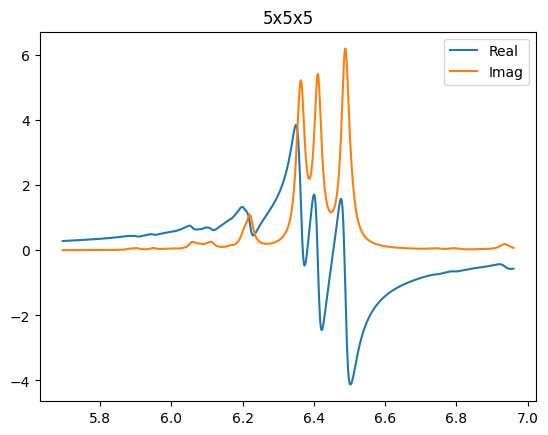

In [19]:
Params['N'], Params['shape'] = to3D(5, 5, 5, 'zyx')
Params['Packing'] = 'Ellipse'
Params['Solver_type'] = 'Volt_fast'
Params['Solver_name'] = 'lgmres'
data_volt = open_model('DATA', Params)
data = data_volt
plt.title(Params['shape'])
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()
plt.show()

In [49]:
Params['N'], Params['shape'] = to3D(10, 10, 10, 'zyx')
Params['Packing'] = 'Rectangle'
Params['Solver_type'] = 'Volt_fast'
Params['Solver_name'] = 'lgmres'
save('DATA', Params)

Rectangle
Rectangle
{'z': [9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.61466

100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


Circvecs: Done
FFT solving (voltage)


100%|██████████| 1000/1000 [12:39<00:00,  1.32it/s]

FFT solving: Done, shape = [('z', (11, 10, 10)), ('y', (10, 11, 10)), ('x', (10, 10, 11))]
Rectangle_NoGrad_10x10x10_zyx_Volt_fast


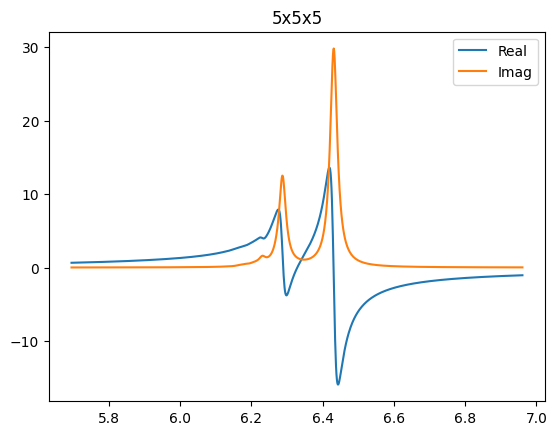

In [17]:
Params['N'], Params['shape'] = to3D(10, 10, 10, 'zyx')
Params['Packing'] = 'Rectangle'
Params['Solver_type'] = 'Volt_fast'
Params['Solver_name'] = 'lgmres'
data_rec = open_model('DATA', Params)
data = data_rec
plt.title(Params['shape'])
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()
plt.show()

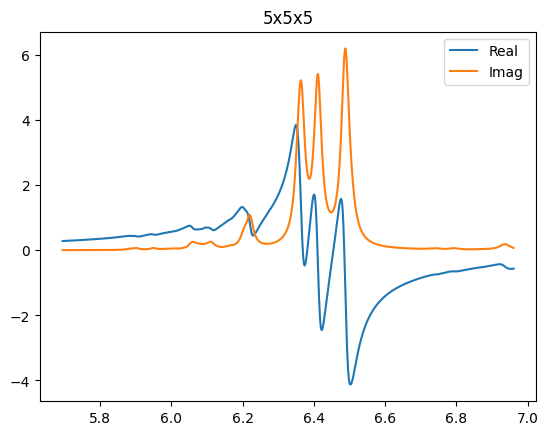

In [40]:


# plt.title('Number of iterations')
# plt.plot(data['Omega']/2/np.pi/1e6, data['Iters'])
# plt.show()



In [26]:
Params['N'], Params['shape'] = to3D(5, 5, 5, 'zyx')
Params['Packing'] = 'Ellipse'
Params['Solver_type'] = 'Straight'
save('DATA', Params)

Ellipse
Ellipse
{'z': [9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649804815e-11, 9.614662649

100%|██████████| 450/450 [00:01<00:00, 237.24it/s]


Matrix: Done
Straight solving (Voltage)


100%|██████████| 1000/1000 [00:34<00:00, 29.13it/s]

Straight solving (Voltage): Done
Ellipse_NoGrad_5x5x5_zyx_Straight


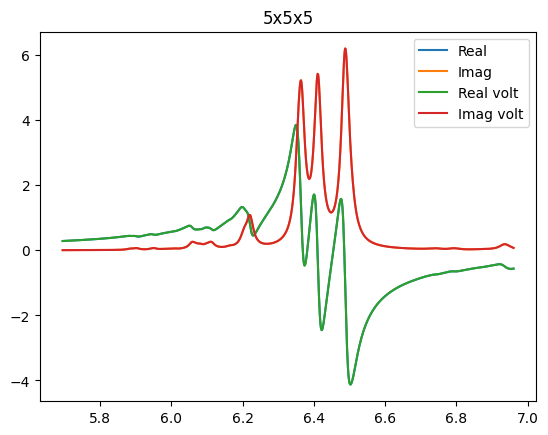

[[0.99999998-2.41848315e-09j 1.0000016 +2.73304209e-07j
  1.00000166+2.62400482e-07j]
 [0.99999999-7.10819925e-10j 0.99999949-1.74275704e-07j
  0.99999956-1.70143975e-07j]
 [0.99999999-7.22589141e-10j 0.99999947-1.83791664e-07j
  0.99999953-1.79587488e-07j]
 ...
 [0.99999992-1.75167758e-07j 0.99999812+6.25605423e-06j
  1.00000091+5.80076143e-07j]
 [0.99999991-1.73935827e-07j 0.99999793+5.82474613e-06j
  1.00000054+5.48551169e-07j]
 [0.99999988-1.53538848e-07j 0.99999602+4.27143427e-06j
  0.99999844-6.51882279e-07j]]


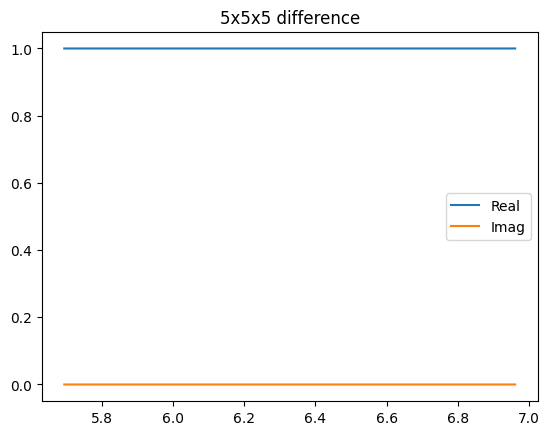

In [28]:
Params['N'], Params['shape'] = to3D(5, 5, 5, 'zyx')
Params['Packing'] = 'Ellipse'
Params['Solver_type'] = 'Straight'
data_straight = open_model('DATA', Params)
data = data_straight
plt.title(Params['shape'])
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.plot(data['Omega']/2/np.pi/1e6, data_volt['Polarization'][:, 0].real, label='Real volt')
plt.plot(data['Omega']/2/np.pi/1e6, data_volt['Polarization'][:, 0].imag, label='Imag volt')
plt.legend()
plt.show()

delta = data_straight['Polarization'] / data_volt['Polarization']
print(delta)
plt.title(Params['shape'] + ' difference')
plt.plot(data['Omega']/2/np.pi/1e6, delta[:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, delta[:, 0].imag, label='Imag')
plt.legend()
plt.show()


In [43]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Пример данных
# data = open_model('DATA', Params)

# omega = data['Omega'] / 2 / np.pi / 1e6
# polarization_imag = data['Polarization'][:, 0].imag  # Мнимая часть поляризуемости
# iterations = data['Iters']
# condition_number = data['Conds']

# fig, ax1 = plt.subplots()

# # Построение первой величины (мнимая часть поляризуемости)
# ax1.set_xlabel('Omega (MHz)')
# ax1.set_ylabel('Polarization Imag', color='tab:blue')
# ax1.plot(omega, polarization_imag, label='Polarization Imag', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# # Создание вторичной оси для второй величины (количество итераций)
# ax2 = ax1.twinx()
# ax2.set_ylabel('Iterations', color='tab:green')
# ax2.plot(omega, iterations, label='Iterations', color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')

# # Создание третьей оси для третьей величины (число обусловленности)
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Смещение третьей оси
# ax3.set_ylabel('Condition Number', color='tab:red')
# ax3.plot(omega, condition_number, label='Condition Number', color='tab:red')
# ax3.tick_params(axis='y', labelcolor='tab:red')

# # Добавление легенд
# fig.tight_layout()
# #fig.legend(loc='center left', bbox_to_anchor=(-0.3, 0.5))

# plt.title('Polarization Imag, Iterations, and Condition Number')
# plt.show()

In [44]:

# Eigvals = np.array(data['Eigenvalues'])
# PrecondEigvals = np.array(data['PrecondEigenvalues'])
# # fig, ax = plt.subplots()
# # dots = ax.scatter(Eigvals[0].real, Eigvals[0].imag, label='Eigenvalues', color = 'blue')

# # def plot_eigval(i):
# #     ax.set_title(f'Eigenvalues for omega = {data["Omega"][i]/2/np.pi/1e6} MHz')
# #     dots.set_offsets(np.c_[Eigvals[i].real, Eigvals[i].imag])
# #     fig.canvas.draw_idle()

# # from ipywidgets import interact
# # interact(plot_eigval, i = (0, len(data['Omega'])-1, 1))
# # plt.show()

# from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots(2, 1)

# def update(i):
#     ax[0].clear()
#     ax[1].clear()
#     plt.suptitle(f'Eigenvalues for omega = {round(data["Omega"][i]/2/np.pi/1e6, 3)} MHz')

#     ax[0].scatter(Eigvals[i].real, Eigvals[i].imag, label='Eigenvalues', color = 'blue')
#     ax[0].set_xlim(-1e-8, 1e-8)
#     ax[0].set_ylim(-1e-8, 1e-8)
#     ax[0].axvline(0, color = 'red')

#     ax[1].scatter(PrecondEigvals[i].real, PrecondEigvals[i].imag, label='Preconditioned Eigenvalues', color = 'green')
#     ax[1].set_xlim(-30, 30)
#     ax[1].set_ylim(-30, 30)
#     ax[1].axvline(0, color = 'red')

#     plt.subplots_adjust(hspace = 0.5)


# ani = FuncAnimation(fig, update, frames = list(range(len(data['Omega'])))[::10], repeat = True)

# ani.save('eigenvalues-cube.gif', writer='pillow', fps=10)


In [45]:
# data = open_model('DATA', Params)

In [46]:
# from Impedance_matrix import Matrix

# packing = Packings[Params['Packing']]

# rings_4d = packing(Params)
# phi_0z_4d = {
#         orientation: list(np.ones(Params['Numbers'][orientation]
#                              ) * (orientation == 'z'
#                                   ) * mu_0*np.pi * Radius ** 2
#                                   ) for orientation in Params['Orientations']
#         }
# rings = sum([rings_4d[orientation] for orientation in rings_4d], [])
# phi_0z = np.array(sum([phi_0z_4d[orientation] for orientation in phi_0z_4d], []))
# L, C, R = [], [], []
# for ring in rings:
#     L.append(ring.L)
#     C.append(ring.C)
#     R.append(ring.R)
# L, C, R = np.array(L), np.array(C), np.array(R)
# M_0 = lambda Omega: (R - 1j * Omega * L + 1j/(Omega * C))/1j/Omega
# # Other part
# M = Matrix(rings)

In [47]:
# Params['N'], Params['shape'] = to3D(1, 10, 10, 'zyx')
# Params['Solver_type'] = 'Fast_scipy'
# Params['Solver_name'] = 'lgmres'
# save('DATA', Params)

In [48]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Пример данных
# data = open_model('DATA', Params)

# omega = data['Omega'] / 2 / np.pi / 1e6
# polarization_imag = data['Polarization'][:, 0].imag  # Мнимая часть поляризуемости
# iterations = data['Iters']
# condition_number = data['Conds']

# fig, ax1 = plt.subplots()

# # Построение первой величины (мнимая часть поляризуемости)
# ax1.set_xlabel('Omega (MHz)')
# ax1.set_ylabel('Polarization Imag', color='tab:blue')
# ax1.plot(omega, polarization_imag, label='Polarization Imag', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# # Создание вторичной оси для второй величины (количество итераций)
# ax2 = ax1.twinx()
# ax2.set_ylabel('Iterations', color='tab:green')
# ax2.plot(omega, iterations, label='Iterations', color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')

# # Создание третьей оси для третьей величины (число обусловленности)
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Смещение третьей оси
# ax3.set_ylabel('Condition Number', color='tab:red')
# ax3.plot(omega, condition_number, label='Condition Number', color='tab:red')
# ax3.tick_params(axis='y', labelcolor='tab:red')

# # Добавление легенд
# fig.tight_layout()
# #fig.legend(loc='center left', bbox_to_anchor=(-0.3, 0.5))

# plt.title('Polarization Imag, Iterations, and Condition Number')
# plt.show()

In [49]:

# Eigvals = np.array(data['Eigenvalues'])
# PrecondEigvals = np.array(data['PrecondEigenvalues'])
# # fig, ax = plt.subplots()
# # dots = ax.scatter(Eigvals[0].real, Eigvals[0].imag, label='Eigenvalues', color = 'blue')

# # def plot_eigval(i):
# #     ax.set_title(f'Eigenvalues for omega = {data["Omega"][i]/2/np.pi/1e6} MHz')
# #     dots.set_offsets(np.c_[Eigvals[i].real, Eigvals[i].imag])
# #     fig.canvas.draw_idle()

# # from ipywidgets import interact
# # interact(plot_eigval, i = (0, len(data['Omega'])-1, 1))
# # plt.show()

# from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots(2, 1)

# def update(i):
#     ax[0].clear()
#     ax[1].clear()
#     plt.suptitle(f'Eigenvalues for omega = {round(data["Omega"][i]/2/np.pi/1e6, 3)} MHz')

#     ax[0].scatter(Eigvals[i].real, Eigvals[i].imag, label='Eigenvalues', color = 'blue')
#     ax[0].set_xlim(-1e-8, 1e-8)
#     ax[0].set_ylim(-1e-8, 1e-8)
#     ax[0].axvline(0, color = 'red')

#     ax[1].scatter(PrecondEigvals[i].real, PrecondEigvals[i].imag, label='Preconditioned Eigenvalues', color = 'green')
#     ax[1].set_xlim(-30, 30)
#     ax[1].set_ylim(-30, 30)
#     ax[1].axvline(0, color = 'red')

#     plt.subplots_adjust(hspace = 0.5)


# ani = FuncAnimation(fig, update, frames = list(range(len(data['Omega'])))[::10], repeat = True)

# ani.save('eigenvalues-flat.gif', writer='pillow', fps=10)

In [50]:
# Params['N'], Params['shape'] = to3D(90, 1, 1, 'zyx')
# Params['Solver_type'] = 'Fast_scipy'
# Params['Solver_name'] = 'lgmres'
# save('DATA', Params)

In [51]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Пример данных
# data = open_model('DATA', Params)

# omega = data['Omega'] / 2 / np.pi / 1e6
# polarization_imag = data['Polarization'][:, 0].imag  # Мнимая часть поляризуемости
# iterations = data['Iters']
# condition_number = data['Conds']

# fig, ax1 = plt.subplots()

# # Построение первой величины (мнимая часть поляризуемости)
# ax1.set_xlabel('Omega (MHz)')
# ax1.set_ylabel('Polarization Imag', color='tab:blue')
# ax1.plot(omega, polarization_imag, label='Polarization Imag', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# # Создание вторичной оси для второй величины (количество итераций)
# ax2 = ax1.twinx()
# ax2.set_ylabel('Iterations', color='tab:green')
# ax2.plot(omega, iterations, label='Iterations', color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')

# # Создание третьей оси для третьей величины (число обусловленности)
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Смещение третьей оси
# ax3.set_ylabel('Condition Number', color='tab:red')
# ax3.plot(omega, condition_number, label='Condition Number', color='tab:red')
# ax3.tick_params(axis='y', labelcolor='tab:red')

# # Добавление легенд
# fig.tight_layout()
# #fig.legend(loc='center left', bbox_to_anchor=(-0.3, 0.5))

# plt.title('Polarization Imag, Iterations, and Condition Number')
# plt.show()

In [52]:

# Eigvals = np.array(data['Eigenvalues'])
# PrecondEigvals = np.array(data['PrecondEigenvalues'])
# # fig, ax = plt.subplots()
# # dots = ax.scatter(Eigvals[0].real, Eigvals[0].imag, label='Eigenvalues', color = 'blue')

# # def plot_eigval(i):
# #     ax.set_title(f'Eigenvalues for omega = {data["Omega"][i]/2/np.pi/1e6} MHz')
# #     dots.set_offsets(np.c_[Eigvals[i].real, Eigvals[i].imag])
# #     fig.canvas.draw_idle()

# # from ipywidgets import interact
# # interact(plot_eigval, i = (0, len(data['Omega'])-1, 1))
# # plt.show()

# from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots(2, 1)

# def update(i):
#     ax[0].clear()
#     ax[1].clear()
#     plt.suptitle(f'Eigenvalues for omega = {round(data["Omega"][i]/2/np.pi/1e6, 3)} MHz')

#     ax[0].scatter(Eigvals[i].real, Eigvals[i].imag, label='Eigenvalues', color = 'blue')
#     ax[0].set_xlim(-1e-8, 1e-8)
#     ax[0].set_ylim(-1e-8, 1e-8)
#     ax[0].axvline(0, color = 'red')

#     ax[1].scatter(PrecondEigvals[i].real, PrecondEigvals[i].imag, label='Preconditioned Eigenvalues', color = 'green')
#     ax[1].set_xlim(-30, 30)
#     ax[1].set_ylim(-30, 30)
#     ax[1].axvline(0, color = 'red')

#     plt.subplots_adjust(hspace = 0.5)


# ani = FuncAnimation(fig, update, frames = list(range(len(data['Omega'])))[::10], repeat = True)

# ani.save('eigenvalues-needle.gif', writer='pillow', fps=10)